# A harmonized Landsat Sentinel-2 (HLS) dataset for benchmarking time series reconstruction methods of vegetation indices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time, gc, os, sys
sys.path.append('')
import seasconv
import fast_hants
import fairly
from skmap.io import RasterData 

## Download the files from Zenodo

In [ ]:
zenodo = fairly.client(id="zenodo")
dataset = zenodo.get_dataset("https://zenodo.org/record/8119407")
dataset.store("./data")

## Compute methods performance on benchmark dataset

Tiles: ['T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV']

In [2]:
def compute_rmse_nrmse(data_ref, data_rec, mask):
    diff = np.array(data_ref[mask] - data_rec[mask], dtype=np.double)
    RMSE = np.sqrt(np.nanmean((diff) ** 2))
    mean_ref = np.nanmean(np.array(data_ref[mask], dtype=np.double))
    NRMSE = RMSE / np.abs(mean_ref)
    return RMSE, NRMSE, mean_ref

In [ ]:
# Parameters
years = np.arange(2015,2023)
n_pix = 3660
n_ipy = 23 # 16-days images (23 images per year)
tiles = ('T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV')
n_t = len(tiles)
n_jobs = 40
try:
    import mkl
    mkl.set_num_threads(n_jobs)
except:
    pass
# Naming detatils:
# RMSE: root mean square error on artificial gaps
# NRMSE: RMSE normalized by the absolute values of the mean
# pct: percentage of filled artificial gaps
# pt/g: per tile/global
# f/i: filled by the method/interception of all methods
# time: total computational time per tile

include_HANTS = False
include_TMWM2 = True

# Initialize variables to store per-tile results
RMSE_pt_i_SeasConv = np.zeros(n_t)
NRMSE_pt_i_SeasConv = np.zeros(n_t)
mean_ref_i_SeasConv = np.zeros(n_t)
RMSE_pt_f_SeasConv = np.zeros(n_t)
NRMSE_pt_f_SeasConv = np.zeros(n_t)
mean_ref_f_SeasConv = np.zeros(n_t)
pct_pt_f_SeasConv = np.zeros(n_t)
time_SeasConv = np.zeros(n_t)
n_elements_pt_i_SeasConv = np.zeros(n_t)
n_elements_pt_f_SeasConv = np.zeros(n_t)

if include_HANTS:
    RMSE_pt_i_HANTS = np.zeros(n_t)
    NRMSE_pt_i_HANTS = np.zeros(n_t)
    mean_ref_i_HANTS = np.zeros(n_t)
    RMSE_pt_f_HANTS = np.zeros(n_t)
    NRMSE_pt_f_HANTS = np.zeros(n_t)
    mean_ref_f_HANTS = np.zeros(n_t)
    pct_pt_f_HANTS = np.zeros(n_t)
    time_HANTS = np.zeros(n_t)
    n_elements_pt_i_HANTS = np.zeros(n_t)
    n_elements_pt_f_HANTS = np.zeros(n_t)
    
if include_TMWM2:
    RMSE_pt_i_TMWM2 = np.zeros(n_t)
    NRMSE_pt_i_TMWM2 = np.zeros(n_t)
    mean_ref_i_TMWM2 = np.zeros(n_t)
    RMSE_pt_f_TMWM2 = np.zeros(n_t)
    NRMSE_pt_f_TMWM2 = np.zeros(n_t)
    mean_ref_f_TMWM2 = np.zeros(n_t)
    pct_pt_f_TMWM2 = np.zeros(n_t)
    time_TMWM2 = np.zeros(n_t)
    n_elements_pt_i_TMWM2 = np.zeros(n_t)
    n_elements_pt_f_TMWM2 = np.zeros(n_t)

for i, tile in enumerate(tiles):
    print(f'Tile number {i+1}: {tile}')
    # Read the reference data
    data_gap = np.zeros((n_ipy*len(years),n_pix,n_pix))
    data_ref = np.zeros((n_ipy*len(years),n_pix,n_pix))
    for j, year in enumerate(years):
        raser_data_ref = RasterData(
            'data/HLS.'+tile+'.{dt}.v2.0.NDVI.tif', verbose=False
            ).timespan(f'{str(year)}001', f'{str(year+1)}001', 'days', 16, date_format="%Y%j", ignore_29feb=False, date_style='start_date'
            ).read(n_jobs=n_jobs)
        data_ref[23*j:23*(i+1),:,:] = np.moveaxis(raser_data_ref.array, 2, 0)
        raser_data_gap = RasterData(
            'data/HLS.'+tile+'.{dt}.v2.0.NDVI_art_gaps.tif', verbose=False
            ).timespan(f'{str(year)}001', f'{str(year+1)}001', 'days', 16, date_format="%Y%j", ignore_29feb=False, date_style='start_date'
            ).read(n_jobs=n_jobs)
        data_gap[23*j:23*(i+1),:,:] = np.moveaxis(raser_data_gap.array, 2, 0)

    # Get the indices of the artificial gaps
    mask_ref = np.isnan(data_ref)
    mask_gap = np.isnan(data_gap)
    mask_art_gap = mask_gap & ~mask_ref
    n_art_gap = np.sum(mask_art_gap)

    # SeasConv
    print("--- Filling with SeasConv")
    start_time = time.time()
    sc = seasconv.SeasConv(ts=data_gap, n_ipy=n_ipy, att_env=10, att_seas=60, n_cpu=n_jobs)
    data_SeasConv, qa_SeasConv = sc.run()
    time_SeasConv[i] = time.time() - start_time
    print(f"------ Total time {time_SeasConv[i]:.2f} s")
    mask_fill_art_gap_SeasConv = mask_art_gap & ~np.isnan(data_SeasConv)
    pct_pt_f_SeasConv[i] = np.sum(mask_fill_art_gap_SeasConv) / n_art_gap
    RMSE_pt_f_SeasConv[i], NRMSE_pt_f_SeasConv[i], mean_ref_f_SeasConv[i] = compute_rmse_nrmse(data_ref, data_SeasConv, mask_fill_art_gap_SeasConv)
    n_elements_pt_f_SeasConv[i] = np.sum(mask_fill_art_gap_SeasConv)

    # HANTS
    if include_HANTS:
        print("--- Filling with HANTS")
        start_time = time.time()
        hgf = fast_hants.FastHANTS(ts=data_gap, n_ipy=n_ipy, n_freq=3, reg_param=0.05, min_ipy_pct = 20)
        hants_data = hgf.run()
        time_HANTS[i] = time.time() - start_time
        print(f"------ Total time {time_HANTS[i]:.2f} s")
        mask_fill_art_gap_HANTS = mask_art_gap & ~np.isnan(hants_data)
        pct_pt_f_HANTS[i] = np.sum(mask_fill_art_gap_HANTS) / n_art_gap
        RMSE_pt_f_HANTS[i], NRMSE_pt_f_HANTS[i], mean_ref_f_HANTS[i] = compute_rmse_nrmse(data_ref, hants_data, mask_fill_art_gap_HANTS)
        n_elements_pt_f_HANTS[i] = np.sum(mask_fill_art_gap_HANTS)

    # TMWM2
    if include_TMWM2:
        print("--- Filling with TMWM2")
        start_time = time.time()
        tmwm2 = gapfiller.TMWM2(ts=data_gap, season_size=n_ipy, time_win_size=7, n_jobs_io=n_jobs, verbose=False)
        data_TMWM2 = np.moveaxis(tmwm2.run(), 0, -1)
        time_TMWM2[i] = time.time() - start_time
        print(f"------ Total time {time_TMWM2[i]:.2f} s")
        mask_fill_art_gap_TMWM2 = mask_art_gap & ~np.isnan(data_TMWM2)
        pct_pt_f_TMWM2[i] = np.sum(mask_fill_art_gap_TMWM2) / n_art_gap
        RMSE_pt_f_TMWM2[i], NRMSE_pt_f_TMWM2[i], mean_ref_f_TMWM2[i] = compute_rmse_nrmse(data_ref, data_TMWM2, mask_fill_art_gap_TMWM2)
        n_elements_pt_f_TMWM2[i] = np.sum(mask_fill_art_gap_TMWM2)

    # Interception
    if include_HANTS & include_TMWM2:
        mask_int = mask_fill_art_gap_SeasConv & mask_fill_art_gap_HANTS & mask_fill_art_gap_TMWM2
    elif include_HANTS:
        mask_int = mask_fill_art_gap_SeasConv & mask_fill_art_gap_HANTS    
    elif include_TMWM2:
        mask_int = mask_fill_art_gap_SeasConv & mask_fill_art_gap_TMWM2  
    else:
        mask_int = mask_fill_art_gap_SeasConv
        
    RMSE_pt_i_SeasConv[i], NRMSE_pt_i_SeasConv[i], mean_ref_i_SeasConv[i] = compute_rmse_nrmse(data_ref, data_SeasConv, mask_int)
    n_elements_pt_i_SeasConv[i] = np.sum(mask_int)
    
    if include_HANTS:
        RMSE_pt_i_HANTS[i], NRMSE_pt_i_HANTS[i], mean_ref_i_HANTS[i] = compute_rmse_nrmse(data_ref, hants_data, mask_int)
        n_elements_pt_i_HANTS[i] = np.sum(mask_int)
    
    if include_TMWM2:
        RMSE_pt_i_TMWM2[i], NRMSE_pt_i_TMWM2[i], mean_ref_i_TMWM2[i] = compute_rmse_nrmse(data_ref, data_TMWM2, mask_int)
        n_elements_pt_i_TMWM2[i] = np.sum(mask_int)

Tile number 1: T22LEH


In [4]:
# Compute global RMSE, NRMSE, and percentage filled
total_elements_i_SeasConv = np.sum(n_elements_pt_i_SeasConv)
total_elements_f_SeasConv = np.sum(n_elements_pt_f_SeasConv)
RMSE_g_i_SeasConv = np.sqrt(np.average(RMSE_pt_i_SeasConv ** 2, weights=n_elements_pt_i_SeasConv))
NRMSE_g_i_SeasConv = RMSE_g_i_SeasConv / np.abs(np.average(mean_ref_i_SeasConv, weights=n_elements_pt_i_SeasConv))
RMSE_g_f_SeasConv = np.sqrt(np.average(RMSE_pt_f_SeasConv ** 2, weights=n_elements_pt_f_SeasConv))
NRMSE_g_f_SeasConv = RMSE_g_f_SeasConv / np.abs(np.average(mean_ref_f_SeasConv, weights=n_elements_pt_f_SeasConv))
pct_g_f_SeasConv = np.sum(pct_pt_f_SeasConv * n_elements_pt_f_SeasConv) / total_elements_f_SeasConv

if include_HANTS:
    total_elements_i_HANTS = np.sum(n_elements_pt_i_HANTS)
    total_elements_f_HANTS = np.sum(n_elements_pt_f_HANTS)
    RMSE_g_i_HANTS = np.sqrt(np.average(RMSE_pt_i_HANTS ** 2, weights=n_elements_pt_i_HANTS))
    NRMSE_g_i_HANTS = RMSE_g_i_HANTS / np.abs(np.average(mean_ref_i_HANTS, weights=n_elements_pt_i_HANTS))
    RMSE_g_f_HANTS = np.sqrt(np.average(RMSE_pt_f_HANTS ** 2, weights=n_elements_pt_f_HANTS))
    NRMSE_g_f_HANTS = RMSE_g_f_HANTS / np.abs(np.average(mean_ref_f_HANTS, weights=n_elements_pt_f_HANTS))
    pct_g_f_HANTS = np.sum(pct_pt_f_HANTS * n_elements_pt_f_HANTS) / total_elements_f_HANTS

if include_TMWM2:    
    total_elements_i_TMWM2 = np.sum(n_elements_pt_i_TMWM2)
    total_elements_f_TMWM2 = np.sum(n_elements_pt_f_TMWM2)
    RMSE_g_i_TMWM2 = np.sqrt(np.average(RMSE_pt_i_TMWM2 ** 2, weights=n_elements_pt_i_TMWM2))
    NRMSE_g_i_TMWM2 = RMSE_g_i_TMWM2 / np.abs(np.average(mean_ref_i_TMWM2, weights=n_elements_pt_i_TMWM2))
    RMSE_g_f_TMWM2 = np.sqrt(np.average(RMSE_pt_f_TMWM2 ** 2, weights=n_elements_pt_f_TMWM2))
    NRMSE_g_f_TMWM2 = RMSE_g_f_TMWM2 / np.abs(np.average(mean_ref_f_TMWM2, weights=n_elements_pt_f_TMWM2))
    pct_g_f_TMWM2 = np.sum(pct_pt_f_TMWM2 * n_elements_pt_f_TMWM2) / total_elements_f_TMWM2

In [5]:
print(f'Respective tile name {tiles}')
print('-------------------------------------------------')
print(f'NRMSE per tile on all fake gaps filled by the method:  \n - SeasConv ->')
print(("{:.2f}, " * len(NRMSE_pt_f_SeasConv)).format(*NRMSE_pt_f_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(NRMSE_pt_f_HANTS)).format(*NRMSE_pt_f_HANTS))
if include_TMWM2: 
    print(' - TMWM2 ->')
    print(("{:.2f}, " * len(NRMSE_pt_f_TMWM2)).format(*NRMSE_pt_f_TMWM2))

print('-------------------------------------------------')
print(f'NRMSE per tile on the intersection of fake gaps filled by all the methods:  \n - SeasConv ->')
print(("{:.2f}, " * len(NRMSE_pt_i_SeasConv)).format(*NRMSE_pt_i_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(NRMSE_pt_i_HANTS)).format(*NRMSE_pt_i_HANTS))
if include_TMWM2: 
    print(' - TMWM2 ->')
    print(("{:.2f}, " * len(NRMSE_pt_i_TMWM2)).format(*NRMSE_pt_i_TMWM2))

print('-------------------------------------------------')
print(f'Overall NRMSE intersection of fake gaps filled by all the methods:  \n - SeasConv ->')
print(f"{NRMSE_g_i_SeasConv:.2f}, ")
if include_HANTS:
    print(' - HANTS ->')
    print(f"{NRMSE_g_i_HANTS:.2f}, ")
if include_TMWM2: 
    print(' - TMWM2 ->')
    print(f"{NRMSE_g_i_TMWM2:.2f}, ")

print('-------------------------------------------------')
print(f'Percentage per tile of fake gaps filled by the method:  \n - SeasConv ->')
print(("{:.2f}, " * len(pct_pt_f_SeasConv)).format(*pct_pt_f_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(pct_pt_f_HANTS)).format(*pct_pt_f_HANTS))
if include_TMWM2: 
    print(' - TMWM2 ->')
    print(("{:.2f}, " * len(pct_pt_f_TMWM2)).format(*pct_pt_f_TMWM2))

print('-------------------------------------------------')
print(f'Computational time per tile for each method:  \n - SeasConv ->')
print(("{:.2f}, " * len(time_SeasConv)).format(*time_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(time_HANTS)).format(*time_HANTS))
if include_TMWM2: 
    print(' - TMWM2 ->')
    print(("{:.2f}, " * len(time_TMWM2)).format(*time_TMWM2))


Respective tile name ('T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV')
-------------------------------------------------
NRMSE per tile on all fake gaps filled by the method:  
 - SeasConv ->
0.13, 0.04, 0.52, 0.71, 1.46, 0.08, 
 - TMWM2 ->
0.16, 0.05, 0.55, 0.80, 1.39, 0.09, 
-------------------------------------------------
NRMSE per tile on the intersection of fake gaps filled by all the methods:  
 - SeasConv ->
0.13, 0.04, 0.52, 0.71, 1.41, 0.08, 
 - TMWM2 ->
0.16, 0.05, 0.55, 0.80, 1.39, 0.09, 
-------------------------------------------------
Overall NRMSE intersection of fake gaps filled by all the methods:  
 - SeasConv ->
0.46, 
 - TMWM2 ->
0.48, 
-------------------------------------------------
Percentage per tile of fake gaps filled by the method:  
 - SeasConv ->
1.00, 1.00, 1.00, 1.00, 0.87, 1.00, 
 - TMWM2 ->
1.00, 1.00, 1.00, 1.00, 0.83, 1.00, 
-------------------------------------------------
Computational time per tile for each method:  
 - SeasConv ->
143

## Visual inspection of the time series reconstruction

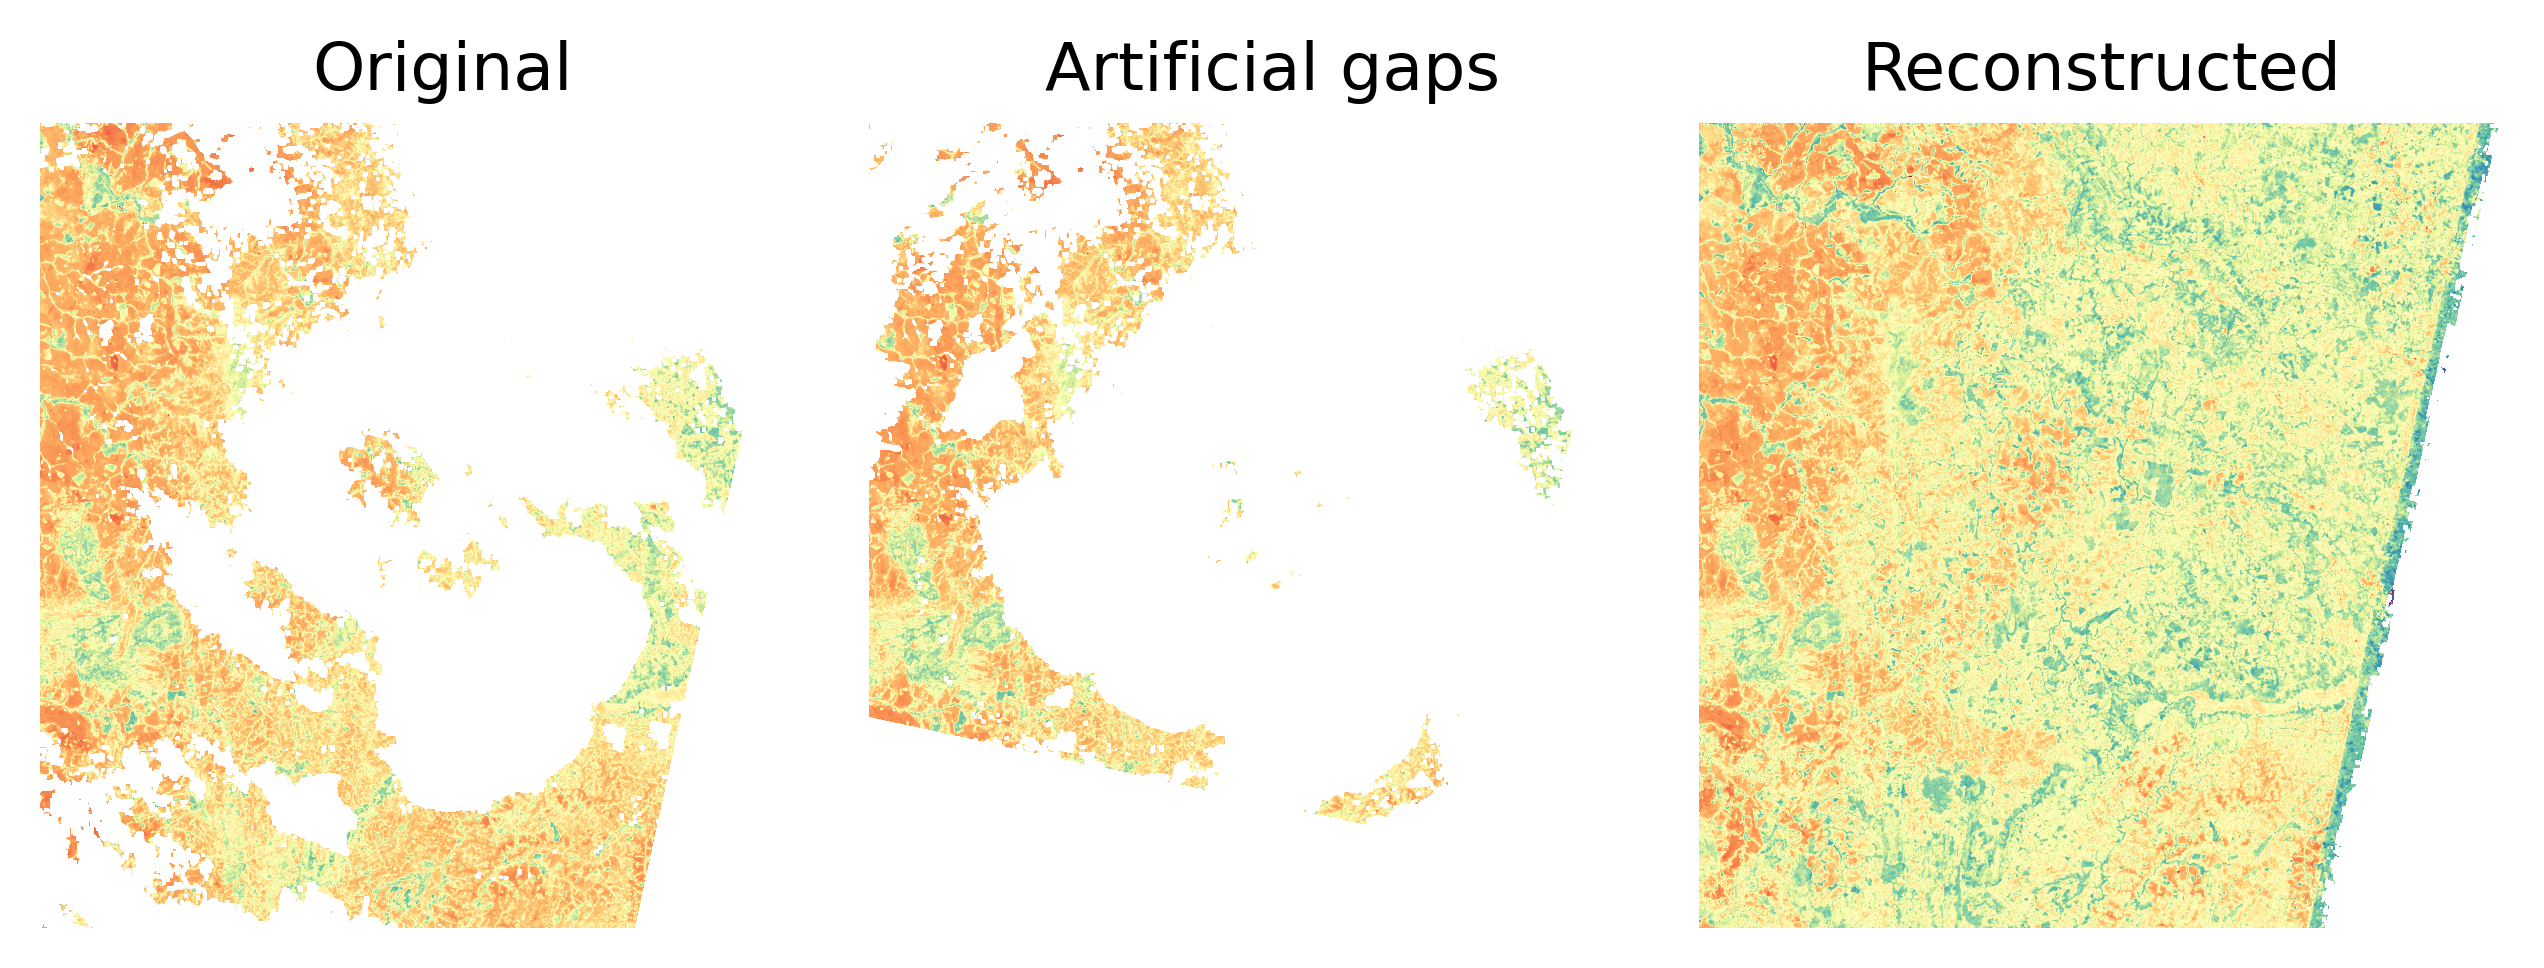

In [27]:
idx = 18
orig_img = data_ref[:,:,idx]
art_gaps_img = data_gap[:,:,idx]
filled_img = data_SeasConv[:,:,idx]
plotter.plot_rasters(
    orig_img,
    art_gaps_img,
    filled_img,
    cmaps='Spectral',
    dpi=400,
    vmin=1,
    vmax=10000,
    figsize=8,
    titles=['Original','Artificial gaps', 'Reconstructed'],
    nodata=-32000
)

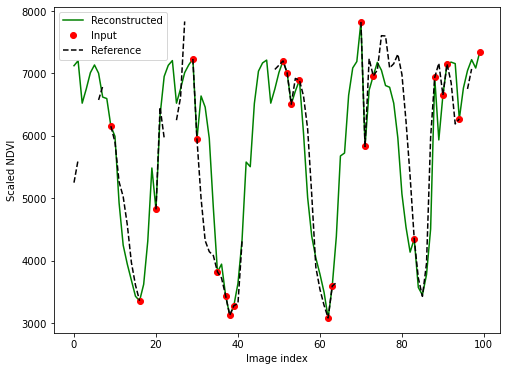

In [45]:
pix_x = 50
pix_y = 40
ref_ts = data_ref[pix_x,pix_y,:]
seasconv_ts = data_SeasConv[pix_x,pix_y,:]
gap_ts = data_gap[pix_x,pix_y,:]
idx = slice(0,100)
plt.figure(figsize=(8,6))
plt.plot(seasconv_ts[idx], 'g', label='Reconstructed')
plt.plot(gap_ts[idx], 'ro', label='Input')
plt.plot(ref_ts[idx], 'k--', label='Reference')
plt.legend()
plt.xlabel('Image index')
plt.ylabel('Scaled NDVI')
plt.savefig('gap_filling_ts.png')
plt.show()